---

# 11-13. 프로젝트: 뉴스기사 요약해보기


In [1]:
# nltk패키지에서 불용어 사전을 다운로드 받고 데이터 전처리를 위한 패키지 불러오기
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj47/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 수집하기


In [2]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')


In [76]:
# 추출적 요약
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
81315,"After 24 yrs, Sridevi, Dutt to star together i...","According to reports, actors Sanjay Dutt and S..."
46947,Punjab woman castrates husband over suspicion ...,A woman in Punjab allegedly cut off her husban...
35892,433 firms under EPFO scanner over PF managemen...,The Employees Provident Fund Organisation (EPF...
27871,Air pollution significant contributor behind d...,A study conducted by the researchers at USA's ...
21909,Spider-shaped robot that can help in medical s...,Researchers from Harvard and Boston have devel...
9472,Nissan Chairman used firmÃ¢ÂÂs assets for pe...,Japanese carmaker Nissan's Chairman Carlos Gho...
21273,Injury-hit Virat Kohli can be more dangerous: ...,England coach Trevor Bayliss has said that Vir...
15847,"Apple stole our chip-making secrets, gave it t...",American chipmaker Qualcomm on Tuesday accused...
32692,You're Avengers fan if you wait for post-credi...,Information and Broadcasting Minister Smriti I...
25893,PM Modi spreading poison of hatred and divisio...,After PM Narendra Modi claimed that he was not...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

In [5]:
# 중복 여부 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# headlines의 경우 간단한 요약으로 같을 수 있지만 text자체가 중복된 건 제거해줘야함
data.drop_duplicates(subset='text', inplace=True)
print('전체샘플 수', len(data))

전체샘플 수 98360


In [7]:
# drop_duplicates()가 중복된 null을 지워주긴 했지만 여전히 남아 있을 수 있음
# .isnull().sum()으로 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [8]:
# 텍스트 정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [9]:
# 불용어 제거
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 전처리 전, 후 결과를 확인하기 위해 임의의 text와 summary를 만들어 함수 호출

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [12]:
# 훈련 데이터 전체에 대해서 전처리
# 이때 text의 경우 불용어를 제거하고 Summary는 불용어를 제거하지 않을 것이므루 따로 호출해서 진행해야함
# text를 전처리하고 결과 출력

clean_text = []

# 전체 Text데이터에 대한 전처리: 10분이상 걸릴 수 있음
for s in data['text']:
    clean_text.append(preprocess_sentence(s))
    
# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [13]:
# summary에 대해서 불용어 제거를 수행하지 안흔 의미에서 두번째 인자를 False로 넣어줌

clean_headlines = []

# 전체 summary데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

In [14]:
# 데이터 정제 과정을 거친 후 empty 샘플이 생겼는지 확인해보느 넋이 좋음
# 데이터 정제 저넹는 데이터가 존재했지만, 정제과정에서 문장의 모든 단어가 사라지는 경우가 있음

# 보다 쉽게 확인하기 위해 데이터프레임에 재저장 그리고 empty값은 null값을 가진 샘플로 대체

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
# .isnull().sum()을 사용하여 Null값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 훈련데이터와 테스트 데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


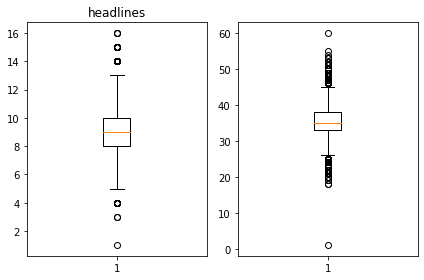

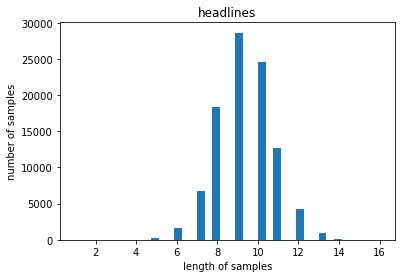

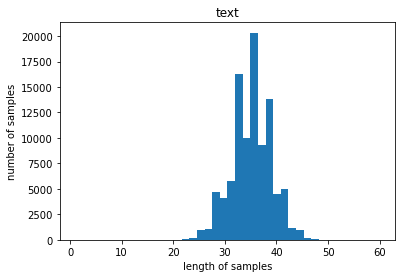

In [16]:
# text와 summary의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화

# 길이 분포 출력 
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
# text 최소1, 최대 60, 평균 35
# headlines 최소 1 최대 16 평균 9

# Text의 최대 길이와 summary의 적절한 최대길이를 임의로 정해봄
text_max_len = 45
headlines_max_len = 12

In [18]:
# 50과 8로 정했을 때 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인
# 훈련 데이터와 샘플의 길이를 입력하면 데이터의 몇%가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
# 위에서 만든 함수를 text와 summary에 적용해 우리가 결정한 임의이 길이가 몇%의 샘플까지 포함하는지 볼 수 있음
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [20]:
# text경우 약 23%의 데이터가 망가진다고 함
# 우리는 정해진 길이에 맞춰서 자르는 것이 아닌, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

data = data[data["text"].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data["headlines"].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 96871


# 시작토큰과 종료토큰 추가

In [21]:
# 요약 데이터에 시작, 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken '+x)
data['decoder_target'] = data['headlines'].apply(lambda x: x+' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [22]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 numpy타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [23]:
# 훈련 데이터와 테스트 데이터 분리
# encoder_input의 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줌

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 5105 94940  4934 ... 20977 48988  1438]


In [24]:
# 위 정수 시퀀스를 이용해 다시 데이터의 샘플 순서로 섞어주면 잘 섞인 샘플이 됨
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
# 8:2의 비율로 훈련 데이터와 테스트 데이터 분리. 
# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정해줌

n_of_val = int(len(encoder_input) * 0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19374


In [26]:
# 위에 정의한 테스트 데이터의 갯수를 이용해 전체 데이터에 양분

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


# 단어 집합 및 정수 인코딩

In [27]:
# Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있음
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 단어로부터 단어 집합 생성

In [28]:
# 단어 집합이 생성되는 동시에 각 단어에 고유 정수가 부여 됨
# 생성된 단어 집합은 src_tokenizer.word_index에 저장됨
# 이렇게 만든 단어 집합에 모든 데이터를 사용하는 것이 아닌 빈도수가 낮은 단어들을 데이터에서 제외하려고 함
# 등장 빈도수가 7회 미만인 단어들 데이터에서 얼만큼 차지하는지 확인
# src_tokenizer.word_counts.items() 단어와 각 단어의 등장 빈도수가 저장되어 있음

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어 등장의 빈도수가 threshold 보다 작으면 
    if(value < threshold):
        rare_cnt = rare_cnt +1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69023
등장 빈도가 6번 이하인 희귀 단어의 수: 47018
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22005
단어 집합에서 희귀 단어의 비율: 68.11932254465903
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.511768131767462


In [29]:
# 등장빈도가 6이하인 단어들은 단어 집합에서 약 68%이상을 차지함
# 하지만 실제 후련데이터에서 등잔 빈도를 차지하는 비중은 약 3.5%
# 그래서 등장 빈도가 6이하인 단어들은 정수 인코딩 과정에서 빼고자 함
# 위에서 이를 제외한 단어 집합의 크기를 약 21974으로 계산했는데 비슷하게 단어 집합의 크기를 20000으로 제한

src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어크기 20000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어집합 재생성

In [30]:
# texts_to_sequence() 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩
# 현재는 단어 집합의 크기를 20000으로 제한했으니 이제 20000이 넘는 숫자들은 존재하지 않음

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 샘플 출력
print(encoder_input_train[:3])

[[134, 626, 501, 743, 596, 1952, 2488, 5560, 250, 714, 72, 15, 1842, 6, 1973, 1076, 7101, 15, 165, 57, 743, 321, 52, 2275, 5615, 727, 5026, 14721, 2660, 6370, 672, 3131, 190, 6190, 41, 3408, 15], [25, 776, 100, 7205, 6517, 7396, 200, 75, 3279, 402, 25, 776, 2168, 118, 974, 193, 75, 136, 589, 4705, 3, 13, 76, 945, 715, 4088, 3169, 634, 6247, 200, 5434, 187, 945, 738, 143, 3279], [920, 1159, 1858, 210, 3529, 134, 741, 161, 5, 143, 6191, 2956, 938, 507, 7102, 2356, 2764, 74, 151, 3651, 210, 992, 17303, 74, 621, 556, 992, 6054, 17, 810]]


In [31]:
# headlines에 대해서도 동일한 작업 진행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29913
등장 빈도가 4번 이하인 희귀 단어의 수: 18465
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11448
단어 집합에서 희귀 단어의 비율: 61.72901414100893
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.014395027446972


In [33]:
# 등장 빈도가 4회 이하인 단어는 집합에서 약 61%
# 하지만 실제 훈련 데이터에서 등장 빈도는 3.9%
# 아까와 동일하게 이 단어들은 모두 제거 어림잡아 10000을 단어 크기로 제한

tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 158, 1291, 186, 1096, 256, 1646, 1591], [1, 7603, 2818, 106, 5, 115, 89, 6426, 5, 1034], [1, 1659, 109, 739, 6, 990, 220, 643, 6107, 7, 129, 4, 13], [1, 5155, 3, 556, 4, 199, 5596, 34], [1, 63, 26, 649, 1874, 1357, 69, 77, 42, 37, 3759, 1474]]
target
decoder  [[158, 1291, 186, 1096, 256, 1646, 1591, 2], [7603, 2818, 106, 5, 115, 89, 6426, 5, 1034, 2], [1659, 109, 739, 6, 990, 220, 643, 6107, 7, 129, 4, 13, 2], [5155, 3, 556, 4, 199, 5596, 34, 2], [63, 26, 649, 1874, 1357, 69, 77, 42, 37, 3759, 1474, 2]]


In [34]:
# 빈도수가 낮은 단어만으로 구성되어잇는 요약문은 0이 됐을수도 있음
# 길이가 0이 된 인덱스를 받아올 것
# 요약문인 decoder_input에는 sostoken, decoder_target에는 eostokendl 들어가있으므로 실제 길이는 1로 나올 것임

# 훈련, 테스트 데이터에 대해서 요약문의 길이가 1인 경우 dorp_train과 drop_test에 저장

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

# 모델 설계

In [36]:
# 함수형 API를 이용해서 인코더 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [37]:
#### 임베딩 벡터의 차원 128로 정의하고, hidden state 크기를 256으로 정의
#### hidden state는 LSTM에서 얼만큼의 수용력(capacity)을 가질지를 정하는 파라미터
#### 이 파라미터는 LSTM 용량크기나 LSTM에서의 뉴론의 갯수로 이해하면 됨
#### 인코더의 LSTM은 3개의 층으로 구성해서 모델의 복잡도를 늘림
#### hidden state의 크기를 늘리느 ㄴ것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있음

In [38]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [39]:
# 디코더 출력층 설계
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [40]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [41]:
# 설계한 디코더의 출력층을 아래와 같이 수정
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [42]:
# 설계한 모델로 훈련 개시
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
303/303 [==============================] - 99s 326ms/step - loss: 5.6128 - val_loss: 5.1971
Epoch 2/50
303/303 [==============================] - 101s 333ms/step - loss: 5.0446 - val_loss: 4.8210
Epoch 3/50
303/303 [==============================] - 98s 324ms/step - loss: 4.7093 - val_loss: 4.5501
Epoch 4/50
303/303 [==============================] - 97s 322ms/step - loss: 4.4374 - val_loss: 4.3499
Epoch 5/50
303/303 [==============================] - 98s 322ms/step - loss: 4.2176 - val_loss: 4.1974
Epoch 6/50
303/303 [==============================] - 98s 322ms/step - loss: 4.0407 - val_loss: 4.0751
Epoch 7/50
303/303 [==============================] - 98s 323ms/step - loss: 3.8931 - val_loss: 3.9843
Epoch 8/50
303/303 [==============================] - 98s 323ms/step - loss: 3.7646 - val_loss: 3.9085
Epoch 9/50
303/303 [==============================] - 97s 321ms/step - loss: 3.6516 - val_loss: 3.8505
Epoch 10/50
303/303 [==============================] - 98s 322ms/step - 

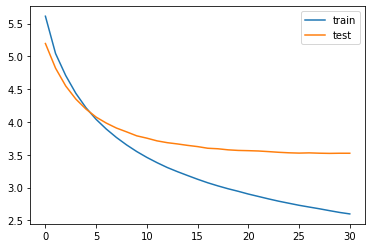

In [43]:
# 훈련 데이터의 손실과 검증 데이터의 손실 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [44]:
# 인퍼런스 모델 구현
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [46]:
# 어텐션 메커니즘알 사용하는 출력층
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

# 모델 테스트

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [49]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former australian captain ian chappell predicted indian spin duo kuldeep yadav yuzvendra chahal excel australia duo also praised credited india success sachin tendulkar chahal yadav managed pick combined wickets sa odi series spin duo bilateral series 
실제 요약 : chahal yadav will in aus ex aus captain ian chappell 
예측 요약 :  shane warne has been an wicket clarke


원문 : road transport highways minister nitin gadkari ruled exemptions toll collection national highways saying people want good services pay agreeing collection toll tax stopped gadkari added cannot promise exemption toll collection 
실제 요약 : pay if you want good services union min on toll exemption 
예측 요약 :  no proposal to stay in vehicles gadkari to gadkari


원문 : following maiden test ton india friday glenn maxwell became second australian shane watson player overall score centuries across three formats west indian chris gayle first cricketer achieve feat smashed balls first match inaugural icc world twenty 
실제 요약 : maxwel

예측 요약 :  jack ma founder becomes world richest man


원문 : us secretary state rex tillerson said country policy strategic patience north korea military action east asian country option table exploring new security diplomatic measures tillerson added said north korea could longer allowed continue developing nuclear technology 
실제 요약 : military action against north korea an option us 
예측 요약 :  us will not allow pressure to north korea


원문 : staff bengaluru st john hospital found two five month old female disposed near hospital premises two separate incidents one foetus found dumped public toilet near hospital emergency ward foetus discovered sanitation tank police cctv footage obtained hospital 
실제 요약 : female found in bengaluru hospital toilet tank 
예측 요약 :  bengaluru police staff found dead in toilet toilet


원문 : actress anushka sharma featured cover women fashion magazine india october issue seen wearing metallic jacket shade gold tommy paired jacket gold earrings cover story titled 

예측 요약 :  plane crash at airport to be held in dubai


원문 : accusing state government responsible madhya pradesh farmers plight congress leader kamal nath saturday said party accepted challenge throwing bjp power assembly elections congress reach masses bjp government true face nath added 
실제 요약 : cong accepts challenge of bjp in mp kamal nath 
예측 요약 :  congress is not being bjp mp on cong mp polls


원문 : india successfully test fired indigenously developed quick reaction surface air short range missile test range odisha coast monday missile developed defence research development organisation bharat electronics limited missile system potential engage multiple targets within range approximately km 
실제 요약 : india successfully test fires quick reaction missile 
예측 요약 :  india successfully test fires missile test fired




## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

# 총평

In [50]:
import requests
from summa.summarizer import summarize

In [86]:

text = requests.get('https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv').text

In [77]:
print(type(data2))

<class 'pandas.core.frame.DataFrame'>


In [81]:
text = str(data2)

In [87]:
print(text[:1500])

headlines,text
upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Ham

In [88]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:


KeyboardInterrupt: 

In [84]:
# 껼과 값 리스트로 출력
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
[]


In [89]:
# 단어의 수로 요약문 크기 조절
print('Summary:')
print(summarize(text, words=50))

Summary:


KeyboardInterrupt: 

i love you를 번역하라면 난 사랑해 널 각각의 단어를 번역해서 주는 것이 제일 간단함  
하지만 한국어는 조금 어색함. 영어는 svo, 한국어는 sov이기 때문에
또 how are you는 잘 지내인데 영어는 3단어 한국어는 2단어 이기때문에 단어별로 반복하는 것은 좋은 방법이 아님

RNN
인코더 -> 디코더 아키텍처 seq2seq
인코더의 역할을 각 단어를 순차적으로 다뤄 문맥벡터를 만드는 것
디코더는 문맥벡터로부터 기계번역을 시작하는건 (start - end)
그러나 이 방법의 경우 단어의 사이즈가 커질 경우 문제가 생김.
문맥벡터는 하나의 고정된 사이즈의 벡터. 문장이 길어질 경우 이것을 고정된 사이즈의 벡터에 담으면 모든 정보를 담을 수 없음
충분한 정보가 없기 때문에 충분한 번역이 안됨

이것을 어떻게 극복할까
그래서 나온게 어텐션 매커니즘
Rnn에서는 인코더의 마지막만 컨텍스트백터로 했고 거기서 디코더로 넘어감
2가지 이점
어텐션에서는 인코더에서 나온 각각의 셀의 state를 활용하면 고정된 컨텍스트 백터의 문제점을 해결할 수 있다.(고정된 컨텍스트 벡터가 아닌 다이나믹한)
인코더의 단어들 중에서 집중해야 할 단어들만 집중할 수 있음

1, 2번은 따라하기만 해서 했지만 3번 루브릭을 해결하지 못했다.. 
어떻게 해야하는지.. 잘 모르겠다 ㅠㅠ 아~!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ㅇㄴㄻㅎㅈㅂㅁㄱ둇ㅎ ㄷㅇㄹ

뉴스 요약은 내가 제일 관심있는 분야의 노드이기도 한데.. 내용을 잘 이해 못하겠다 ㅠㅠ  
노드를 차근차근 하나씩 보면서 이해하고 공부해야할텐데... 그렇게 하면 뭔가 보일텐데... 좀 지쳐서 그런지 뭔가 머리에 잘 안들어온다..
이제 아이펠을 약 2개월 정도 진행했는데... 아직도 뭘 제대로 이해하는 것 없이 제출만 하는 것 같아서 답답하다.  
한 달 전과 비교 했을 때 흥미도가 조금 떨어진 것 같다. 이전에는 노드에 대해 조금이라도 이해하고 풀어보려고 저녁까지 공부했지만, 두 달 동안 내가 느끼기에는 내가 성장하는..? 느낌을 받지 못하고.. 어차피 내가 노드를 이해 못한다고? 생각해서 그런지, 제출시간이 촉박하니 대충 해서 제출만 하자는 생각만 하는 것 같다.  
그래도 희망적인건 파이썬은 조금씩 배우는 것 같다. 물론 이 말이 내가 파이썬을 잘한다는 것도 아니고 지금까지 배운걸 다 활용할 수 있다는 뜻도 아니다. 그래도 파이썬은 기초부터? 배워서 그런지 코드는 퍼실님들이 말씀하셨던 '필요할 때 찾아서 쓸 수 있는' 시도는 해볼 수 있는 것 같다. 

다시 재밌게 하는 것에 목표를 다잡고 마음을 환기 시켜야겠다~! 화이팅!